In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
from PIL import Image
from tqdm import tqdm
from sklearn.utils import shuffle, resample
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from skimage.io import imread, imshow
from skimage.transform import resize
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import ResNet50, DenseNet121,EfficientNetB1
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,Input, UpSampling2D, GlobalAveragePooling2D,concatenate,Conv2DTranspose
from keras.models import Sequential,load_model,Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.losses import categorical_crossentropy
import random
import keras.backend as K

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
path = '/kaggle/input/severstal-steel-defect-detection'
train_df = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')
data_folder = '/kaggle/input/severstal-steel-defect-detection/train_images'
test_folder = '/kaggle/input/severstal-steel-defect-detection/test_images'
input_shape = (128,128)

In [4]:
df1 = train_df[train_df.ClassId == 1]
df2 = train_df[train_df.ClassId == 2]
df3 = train_df[train_df.ClassId == 3]
df4 = train_df[train_df.ClassId == 4]
print(df1.shape, df2.shape, df3.shape, df4.shape)

(897, 3) (247, 3) (5150, 3) (801, 3)


In [5]:
df3_undersampled = resample(df3, replace=False, n_samples=1500, random_state=42)  
df1_oversampled = resample(df1, replace=True, n_samples=1500, random_state=42)  
df2_oversampled = resample(df2, replace=True, n_samples=1500, random_state=42)  
df4_oversampled = resample(df4, replace=True, n_samples=1500, random_state=42)  

balanced_data = pd.concat([df1_oversampled, df2_oversampled, df3_undersampled, df4_oversampled])
balanced_data = balanced_data.sample(frac=1, random_state=42)
balanced_data

,ImageId,ClassId,EncodedPixels
2399,599251689.jpg,2,203265 128 203521 2688
6433,e7aff0392.jpg,3,377809 12 378063 26 378318 27 378572 29 378827...
2946,6c62c50e3.jpg,1,8844 5 9090 15 9341 20 9597 20 9853 20 10109 2...
6481,e97006670.jpg,2,243457 151 243713 151 243969 152 244225 152 24...
4659,a9914e83b.jpg,4,80985 3 81237 9 81490 14 81742 20 81995 25 822...
...,...,...,...
5552,c802d3e11.jpg,3,4845 5 5101 14 5357 19 5613 19 5869 19 6125 19...
3002,6e71531ae.jpg,4,113394 2 113647 7 113900 11 114153 16 114406 2...
3652,84e51db1c.jpg,4,126369 6 126623 16 126877 27 126965 3 126993 6...
6627,ee83f88d5.jpg,4,340436 5 340686 13 340936 22 341186 30 341438 ...


<Axes: >

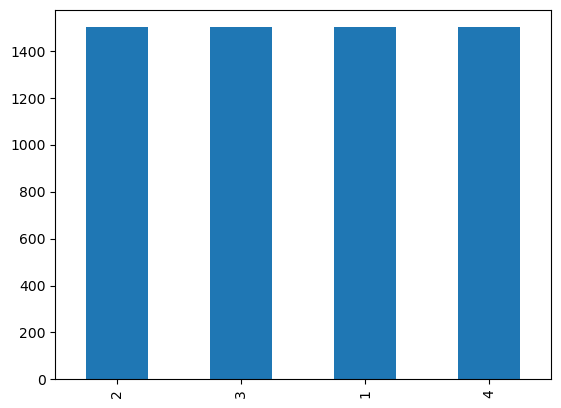

In [6]:
balanced_data["ClassId"].value_counts().plot(kind = 'bar')

In [7]:
def rle_decode(mask_rle: str = '', shape: tuple = (256, 1600)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def make_mask(balanced_data: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (256, 1600)):
    encoded_masks = balanced_data.loc[balanced_data['ImageId'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1]), dtype=np.float32)
    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :] = mask
    return masks

def get_img(x, folder: str='Train_images'):
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [8]:
test_list = []
for file in os.listdir(test_folder):
    imgpath = os.path.join(test_folder, file)
    imgtest = cv2.imread(imgpath)
    imgtest = cv2.resize(imgtest, input_shape)
    test_list.append(imgtest)

In [9]:
img_list = balanced_data["ImageId"].tolist()
label_list = balanced_data["ClassId"].tolist()
img_list[0:5], label_list[0:5]

(['599251689.jpg',
  'e7aff0392.jpg',
  '6c62c50e3.jpg',
  'e97006670.jpg',
  'a9914e83b.jpg'],
 [2, 3, 1, 2, 4])

In [10]:
image_list = []
mask_list = []
for img in img_list:
    image = get_img(img)
    image = cv2.resize(image, input_shape)
    mask = make_mask(balanced_data, img)
    mask = cv2.resize(mask, input_shape)
    image_list.append(image)
    mask_list.append(mask)

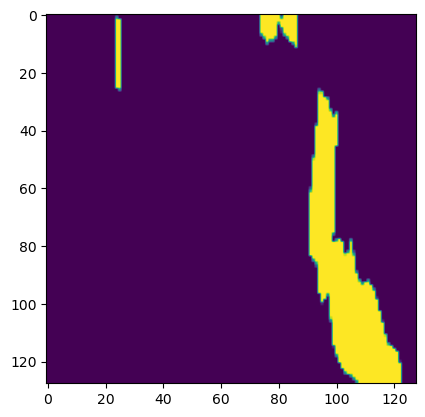

In [11]:
plt.imshow(mask_list[105])

In [12]:
X = np.array(image_list)
y = np.array(mask_list)
encoded = LabelEncoder()
z=encoded.fit_transform(label_list)
z=to_categorical(z)
print(X.shape, y.shape, z.shape)

(6000, 128, 128, 3) (6000, 128, 128) (6000, 4)


In [13]:
X_train, X_val, y_train, y_val, z_train, z_val = train_test_split(X, y, z, test_size=0.2, shuffle=True)

In [14]:
num_classes = 1
inputs = tf.keras.layers.Input((128, 128, 3))

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

In [15]:
seg_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)

In [16]:
seg_history = seg_model.fit(X_train, y_train, epochs =45, batch_size=32, validation_data=(X_val, y_val), callbacks=[lrd])

Epoch 1/45


2023-08-12 15:29:52.072696: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


150/150 [==============================] - 35s 76ms/step - loss: 0.2963 - accuracy: 0.9320 - val_loss: 0.2096 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 2/45
150/150 [==============================] - 10s 70ms/step - loss: 0.1475 - accuracy: 0.9600 - val_loss: 0.1877 - val_accuracy: 0.9318 - lr: 0.0010
Epoch 3/45
150/150 [==============================] - 10s 70ms/step - loss: 0.1205 - accuracy: 0.9620 - val_loss: 0.1159 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 4/45
150/150 [==============================] - 10s 69ms/step - loss: 0.1099 - accuracy: 0.9632 - val_loss: 0.1005 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 5/45
150/150 [==============================] - 11s 71ms/step - loss: 0.1033 - accuracy: 0.9647 - val_loss: 0.0983 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 6/45
150/150 [==============================] - 11s 71ms/step - loss: 0.0986 - accuracy: 0.9654 - val_loss: 0.0917 - val_accuracy: 0.9685 - lr: 0.0010
Epoch 7/45
150/150 [==============================] - 10s 70ms/step -

1/1 [==============================] - 1s 683ms/step


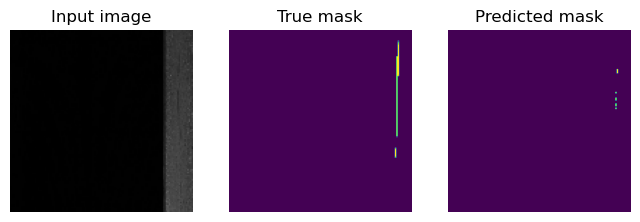

In [17]:
def display(display_list):
    plt.figure(figsize=(8, 8))
    title = ['Input image', 'True mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

i = random.randint(0, len(X_val) - 1)
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = seg_model.predict(sample_image[np.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask, predicted_mask])


In [18]:
prediction = seg_model.predict(sample_image[np.newaxis, ...])[0]
print(tf.reduce_max(prediction))

1/1 [==============================] - 0s 21ms/step
tf.Tensor(0.579232, shape=(), dtype=float32)


In [19]:
X_train=X_train/255
x_val=X_val/255

In [20]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


In [21]:
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB1
class_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x_train = class_model.output
x_train = GlobalAveragePooling2D()(x_train)
x_train = Dense(512, activation='relu')(x_train)
x_train = Dropout(0.2)(x_train)
x_train = Dense(256, activation='relu')(x_train)
x_train = Dropout(0.2)(x_train)
x_train = Dense(128, activation='relu')(x_train)
x_train = Dropout(0.2)(x_train)
x_train = Dense(64, activation='relu')(x_train)
x_train = Dropout(0.2)(x_train)
predictions = Dense(4, activation='softmax')(x_train)
class_model = Model(inputs=class_model.input, outputs=predictions)

27164032/27164032 [==============================] - 0s 0us/step


In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=5, min_lr=1e-8)
class_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
batch_size = 64
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train,z_train, batch_size=batch_size)

In [24]:
class_history = class_model.fit(train_generator,epochs=35,validation_data=(x_val,z_val), batch_size=batch_size, verbose=1, callbacks=[lr_callback])

Epoch 1/35


2023-08-12 15:40:01.555963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


75/75 [==============================] - 98s 453ms/step - loss: 0.9061 - accuracy: 0.6290 - val_loss: 1.3365 - val_accuracy: 0.4275 - lr: 0.0010
Epoch 2/35
75/75 [==============================] - 27s 360ms/step - loss: 0.6448 - accuracy: 0.7700 - val_loss: 0.8611 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/35
75/75 [==============================] - 26s 351ms/step - loss: 0.5653 - accuracy: 0.8062 - val_loss: 1.7724 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 4/35
75/75 [==============================] - 26s 341ms/step - loss: 0.5079 - accuracy: 0.8183 - val_loss: 1.2681 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 5/35
75/75 [==============================] - 26s 343ms/step - loss: 0.4448 - accuracy: 0.8454 - val_loss: 0.5647 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 6/35
75/75 [==============================] - 27s 353ms/step - loss: 0.4319 - accuracy: 0.8517 - val_loss: 0.6062 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 7/35
75/75 [==============================] - 26s 352ms/step - loss: 

1/1 [==============================] - 2s 2s/step


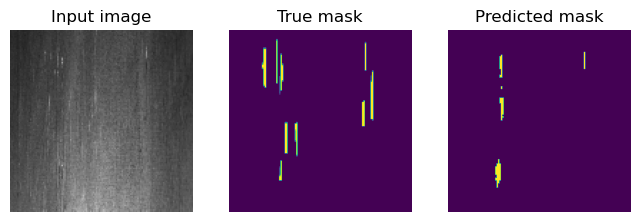

Type defect:  2


In [25]:
i = random.randint(0, len(X_val) - 1)
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = seg_model.predict(sample_image[np.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
prediction_class = class_model.predict(sample_image[np.newaxis, ...])[0]
display([sample_image, sample_mask, predicted_mask])
print("Type defect: " ,np.argmax(prediction_class))

1/1 [==============================] - 0s 31ms/step


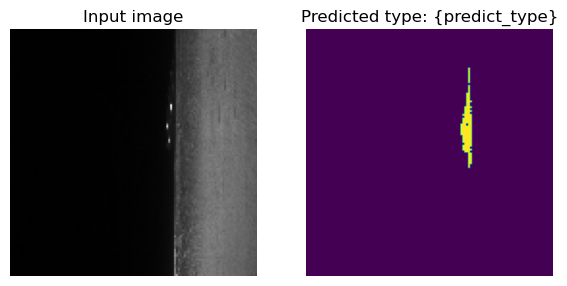

Type defect:  0


In [32]:
def display_test(display_list):
    plt.figure(figsize=(7, 7))
    title = ['Input image', 'Predicted type: {predict_type}']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

X_test = np.array(test_list)
i = random.randint(0, len(X_test) - 1)
sample_image = X_test[i]
prediction = seg_model.predict(sample_image[np.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
prediction_class = class_model.predict(sample_image[np.newaxis, ...])[0]
display_test([sample_image, predicted_mask])
print("Type defect: " ,np.argmax(prediction_class))

In [33]:
def plot_training_history(history):
    
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.subplot(1, 2, 1)  
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train')
    plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)  
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

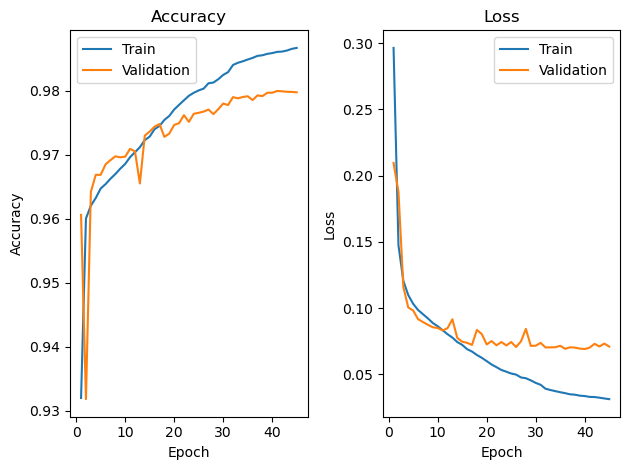

In [34]:
plot_training_history(seg_history)

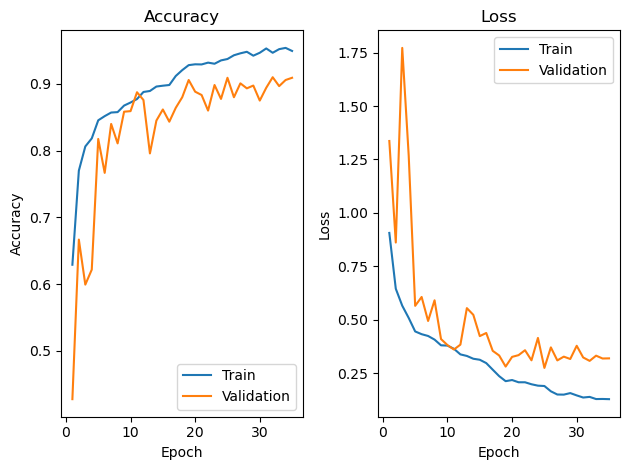

In [35]:
plot_training_history(class_history)